In [1]:
pip install gymnasium

Note: you may need to restart the kernel to use updated packages.


In [2]:
# import gymnasium as gym
import gym

import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = gym.make("CartPole-v0")

random.seed(20)
np.random.seed(20)
torch.manual_seed(20)

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

In [3]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

###Q Networks

In [5]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

### Training

In [7]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state = env.reset()
env.seed(20)
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

### Training Loop

In [9]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

Completeation 100 rewards 200


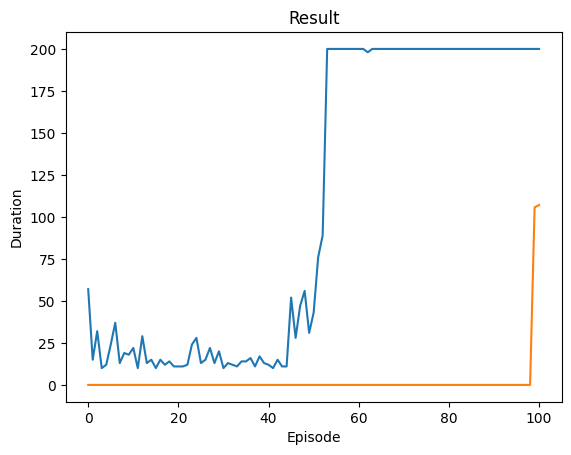

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [10]:
if torch.cuda.is_available() or torch.backends.mps.is_available():
    num_episodes = 1000
else:
    num_episodes = 50

# Get thresholds from environment constraints
theta_threshold = (env.observation_space.high[2]) / 2 - 0.001  # Pole angle
x_threshold = env.observation_space.high[0]  # Cart position


reward_records = []
for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    env.seed(i_episode)
    state = env.reset()
    env.seed(i_episode)
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated = env.step(action.item())
        
        # Compute custom rewards
        # Extract state variables
        x = abs(observation[0])  # Cart position (absolute value)
        theta = abs(observation[2])  # Pole angle (absolute value)
        weight1=0.175
        cart = np.exp((x_threshold - x) / x_threshold) - 0.999  # Cart position reward
        angle = np.exp((theta_threshold - theta) / theta_threshold) - 0.999  # Pole angle reward
        reward = np.float32((weight1 * cart) + ((1-weight1) * angle))  # Combined reward
       
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            # plot_durations()
            break
            
    reward_records.append(t+1)
    print("Run iteration {} rewards {:3}".format(i_episode, t+1), end="\r")
    
    if np.average(reward_records[-50:]) >= 195:
        break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

In [13]:
# type(reward), reward, np.float32(reward)

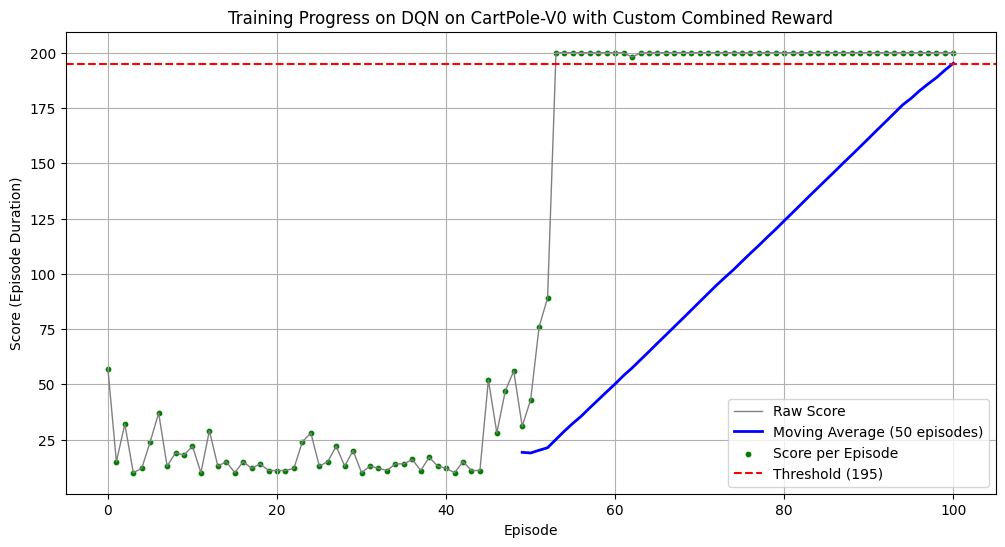

In [15]:
# Calculate a moving average with a window size of 50
def plot_train(name, score_array, window_size = 50):
    if len(score_array) >= window_size:
        moving_avg = np.convolve(score_array, np.ones(window_size) / window_size, mode='valid')
    else:
        moving_avg = score_array  # If not enough data points, use the raw scores

    # Plot the raw scores and the moving average
    plt.figure(figsize=(12, 6))
    plt.plot(score_array, color='gray', linewidth=1, label='Raw Score')
    plt.plot(range(window_size - 1, len(score_array)), moving_avg, color='blue', linewidth=2, label=f'Moving Average ({window_size} episodes)')
    plt.scatter(range(len(score_array)), score_array, color='green', s=10, label='Score per Episode')
    plt.axhline(y=195, color='red', linestyle='--', label='Threshold (195)')

    # Labels and title
    plt.xlabel('Episode')
    plt.ylabel('Score (Episode Duration)')
    # plt.title('Training Progress of %s on CartPole with Custom Combined Reward'%(name))
    plt.title('Training Progress on %s with Custom Combined Reward'%(name))
    
    plt.legend()
    plt.grid(True)
    plt.show()
    
plot_train('DQN on CartPole-V0', reward_records, 50)

[200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0]
count    100.0
mean     200.0
std        0.0
min      200.0
25%      200.0
50%      200.0
75%      200.0
max      200.0
Name: score, dtype: float64
success
True    100
Name: count, dtype: int64


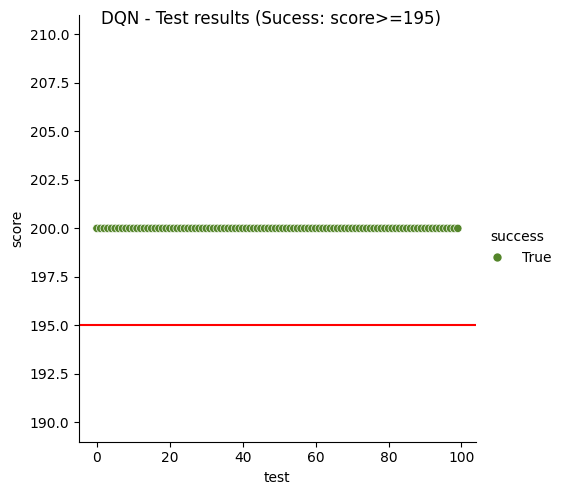

In [17]:
import pandas as pd
import seaborn as sns

def test_agent(i, print_reward=False):
    env = gym.make('CartPole-v0')
    env.seed(i)
    s = env.reset()
    env.seed(i)
    rewards = []
    obs=[]
    for t in range(200):
        s = torch.tensor(s, dtype=torch.float32, device=device).unsqueeze(0)
        
        action = select_action(s)
        s, r, term, trunc= env.step(action.item())
        done = term or trunc
        rewards.append(r)
        #print(sum(rewards))  
        if done:
            rew = sum(rewards)
            if print_reward:
                print("Reward:", rew)
            return rew
    env.close()


def plot_test_results(method='', total=100):
    test_scores = []
    for i in range(total):
        test_scores.append(test_agent(i, print_reward=False))
        
    print(test_scores)

    colors = {True: "#54852A", False: "#E33079"}
    
    test_df= pd.DataFrame({'test':range(total), 'score':test_scores})
    test_df['success'] = test_df['score'].apply(lambda x: x>=195)
    print(test_df['score'].describe())
    c = test_df['success'].value_counts()
    print(c)
    # ax = sns.barplot(c)
    # ax.bar_label(ax.containers[0], fontsize=10);
    # plt.show()
    ax = sns.relplot(data=test_df, x="test", y="score", hue="success", palette=colors)
    # ax.set_title('Test results sucess')
    # ax.set_ylabel('Reward')
    
    ax.fig.suptitle(method + " - Test results (Sucess: score>=195)")
    plt.axhline(y=195, color='r', linestyle='-')
    
    plt.show()
    
plot_test_results('DQN', total=100)